<!-- General condition: The stock price is above its 200 day Moving average
    
Buy decision if:
    10 period RSI of the stock is below 30
    ==>> Buy on the next day open

Sell decision if:
    10-period RSI is above 40 or after 10 trading days
    ==>> Sell on next day open -->

# General condition: The stock price is above its 200-day Moving average
    
#     Buy decision if: 20 period RSI of the stock is below 30
#         ==>> buy on next day open
    
#     Sell decision if:

#         20_period RSI is above 40 or after 10 trading days
#         ==>> sell on next day open
        


# (BITCOIN)
        
    
        

In [28]:
import pandas as pd
import numpy as np
from binance.client import Client
from binance import BinanceSocketManager
from binance.enums import*
from binance.exceptions import BinanceAPIException, BinanceOrderException
import time
import os
#client.get_historical_klines('BTCUSDT','1m','30 m ago UTC')
api_key=os.environ.get('binance_api')
api_secret=os.environ.get('binance_secret')



client=Client(api_key,api_secret)
bsm=BinanceSocketManager(client)
socket=bsm.trade_socket('BTCUSDT')
await socket.__aenter__()
msg=await socket.recv()
#print(api_key,api_secret)


In [29]:
def getmindata(symbol, interval, start):
    frame=pd.DataFrame(client.get_historical_klines(symbol, interval, start))
    frame=frame.iloc[:,:6]
    frame.columns=['opentime',"open",'high','low','close','volume']
    frame=frame.set_index('opentime')
    frame.index=pd.to_datetime(frame.index, unit='ms')
  
   # frame.closetime=pd.to_datetime(frame.closetime, unit='ms')
    frame=frame.astype(float)    
    frame.reset_index(inplace=True)        
    return frame

In [30]:
df=getmindata('BTCUSDT','1d','2 year ago UTC')
df

,opentime,open,high,low,close,volume
0,2021-06-13,35546.12,39380.00,34757.00,39020.57,86921.025555
1,2021-06-14,39020.56,41064.05,38730.00,40516.29,108522.391949
2,2021-06-15,40516.28,41330.00,39506.40,40144.04,80679.622838
3,2021-06-16,40143.80,40527.14,38116.01,38349.01,87771.976937
4,2021-06-17,38349.00,39559.88,37365.00,38092.97,79541.307119
...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.510830
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.709700
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.601080
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.295950


In [31]:
df['MA200']=df['close'].rolling(window=200).mean()
df

,opentime,open,high,low,close,volume,MA200
0,2021-06-13,35546.12,39380.00,34757.00,39020.57,86921.025555,NaN
1,2021-06-14,39020.56,41064.05,38730.00,40516.29,108522.391949,NaN
2,2021-06-15,40516.28,41330.00,39506.40,40144.04,80679.622838,NaN
3,2021-06-16,40143.80,40527.14,38116.01,38349.01,87771.976937,NaN
4,2021-06-17,38349.00,39559.88,37365.00,38092.97,79541.307119,NaN
...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.510830,23389.07830
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.709700,23442.56090
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.601080,23490.63225
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.295950,23537.24445


In [32]:
df=df.dropna()
df

,opentime,open,high,low,close,volume,MA200
199,2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.87000,47748.59765
200,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,47789.09915
201,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,47817.60235
202,2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,47855.49540
203,2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,47900.18125
...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.51083,23389.07830
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.70970,23442.56090
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.60108,23490.63225
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.29595,23537.24445


# RSI=100-[100/(1+(AVG_GAIN/AVG_LOSS))]

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
df['price change']=df['close'].pct_change()
df

,opentime,open,high,low,close,volume,MA200,price change
199,2021-12-29,47543.74,48139.08,46096.99,46464.66,39498.87000,47748.59765,NaN
200,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,47789.09915,0.014123
201,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,47817.60235,-0.019183
202,2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,47855.49540,0.032579
203,2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,47900.18125,-0.009146
...,...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.51083,23389.07830,0.006047
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.70970,23442.56090,-0.000785
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.60108,23490.63225,-0.024043
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.29595,23537.24445,0.003264


In [38]:
df=df.dropna()


In [39]:
df['upmove']=df['price change'].apply(lambda x:x if x>0 else 0)
df['downmove']=df['price change'].apply(lambda x:x if x<0 else 0)
df['avg up']=df['upmove'].ewm(span=20).mean()
df['avg down']=df['downmove'].ewm(span=20).mean()
df

,opentime,open,high,low,close,volume,MA200,price change,upmove,downmove,avg up,avg down
200,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,47789.09915,0.014123,0.014123,0.000000,0.014123,0.000000
201,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,47817.60235,-0.019183,0.000000,-0.019183,0.006708,-0.010071
202,2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,47855.49540,0.032579,0.032579,0.000000,0.016208,-0.006373
203,2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,47900.18125,-0.009146,0.000000,-0.009146,0.011529,-0.007174
204,2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,47941.94690,-0.017766,0.000000,-0.017766,0.008740,-0.009736
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.51083,23389.07830,0.006047,0.006047,0.000000,0.009077,-0.010560
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.70970,23442.56090,-0.000785,0.000000,-0.000785,0.008213,-0.009629
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.60108,23490.63225,-0.024043,0.000000,-0.024043,0.007430,-0.011002
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.29595,23537.24445,0.003264,0.003264,0.000000,0.007034,-0.009954


In [40]:
df['RSI']=df['avg up']/df['avg down']
df['RSI']=df['RSI'].apply(lambda x: 100-(100/(x+1)))
df

,opentime,open,high,low,close,volume,MA200,price change,upmove,downmove,avg up,avg down,RSI
200,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,47789.09915,0.014123,0.014123,0.000000,0.014123,0.000000,100.000000
201,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,47817.60235,-0.019183,0.000000,-0.019183,0.006708,-0.010071,-199.475251
202,2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,47855.49540,0.032579,0.032579,0.000000,0.016208,-0.006373,164.802034
203,2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,47900.18125,-0.009146,0.000000,-0.009146,0.011529,-0.007174,264.707709
204,2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,47941.94690,-0.017766,0.000000,-0.017766,0.008740,-0.009736,-877.919622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.51083,23389.07830,0.006047,0.006047,0.000000,0.009077,-0.010560,-612.137204
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.70970,23442.56090,-0.000785,0.000000,-0.000785,0.008213,-0.009629,-579.828282
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.60108,23490.63225,-0.024043,0.000000,-0.024043,0.007430,-0.011002,-208.060005
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.29595,23537.24445,0.003264,0.003264,0.000000,0.007034,-0.009954,-240.849729


In [41]:
df.loc[(df['close']>df['MA200']) & (df['RSI']<30), 'BUY']=1
df.loc[(df['close']<df['MA200']) | (df['RSI']>30), 'BUY']=0
df

,opentime,open,high,low,close,volume,MA200,price change,upmove,downmove,avg up,avg down,RSI,BUY
200,2021-12-30,46464.66,47900.00,45900.00,47120.87,30352.29569,47789.09915,0.014123,0.014123,0.000000,0.014123,0.000000,100.000000,0.0
201,2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.99796,47817.60235,-0.019183,0.000000,-0.019183,0.006708,-0.010071,-199.475251,0.0
202,2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,47855.49540,0.032579,0.032579,0.000000,0.016208,-0.006373,164.802034,0.0
203,2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,47900.18125,-0.009146,0.000000,-0.009146,0.011529,-0.007174,264.707709,0.0
204,2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,47941.94690,-0.017766,0.000000,-0.017766,0.008740,-0.009736,-877.919622,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-06-08,26339.34,26810.00,26210.00,26498.61,31075.51083,23389.07830,0.006047,0.006047,0.000000,0.009077,-0.010560,-612.137204,1.0
726,2023-06-09,26498.62,26783.33,26269.91,26477.81,27934.70970,23442.56090,-0.000785,0.000000,-0.000785,0.008213,-0.009629,-579.828282,1.0
727,2023-06-10,26477.80,26533.87,25358.00,25841.21,64944.60108,23490.63225,-0.024043,0.000000,-0.024043,0.007430,-0.011002,-208.060005,1.0
728,2023-06-11,25841.22,26206.88,25634.70,25925.55,30014.29595,23537.24445,0.003264,0.003264,0.000000,0.007034,-0.009954,-240.849729,1.0


In [42]:

i=0
money=100

ds=pd.DataFrame()






while i<len(df):
    ##LONG STRATEGY
    if (df.iloc[i,13]==1):
        
   
       
        a=i+1
       
      
        while a<len(df):

            if (df.iloc[a,12]>=40) | (a-i==10):
                profit=((df.iloc[a+1,1]-df.iloc[i+1,1])/df.iloc[i+1,1])
                money=money+money*profit
                ds=ds.append({"buy_time":df.iloc[i+1,0],"buy_price":df.iloc[i+1,1],'sell_time'\
                :df.iloc[a+1,0],'sell_price':df.iloc[a+1,1],'profit%':profit,'money':money,}, ignore_index=True)
                
                i=a+1                  
                break

            else:

                a=a+1
        i=a+1
         
       
     
   
    else:
    
        i=i+1
                            

            
print(ds)
print(f'net profit%={money-100}%')


   buy_price   buy_time       money   profit%  sell_price  sell_time
0   21797.83 2023-02-10  101.844266  0.018443    22199.84 2023-02-15
1   23184.04 2023-02-25  103.473183  0.015994    23554.85 2023-02-27
2   23141.57 2023-03-01  105.656033  0.021096    23629.76 2023-03-02
3   22354.34 2023-03-04  113.964751  0.078639    24112.27 2023-03-14
4   28797.10 2023-04-20  112.453735 -0.013259    28415.29 2023-04-27
5   28068.26 2023-05-02  114.863968  0.021433    28669.85 2023-05-03
6   28430.09 2023-05-08  110.724878 -0.036035    27405.62 2023-05-18
7   26821.28 2023-05-19  115.859303  0.046371    28065.01 2023-05-29
8   27210.36 2023-06-01  115.996536  0.001184    27242.59 2023-06-03
9   27069.22 2023-06-04  116.685807  0.005942    27230.07 2023-06-07
net profit%=16.68580723270533%


In [43]:
#WIN RATIO
wins=[i for i in ds['profit%'] if i>0]
wins
len(wins)/len(ds)

0.8

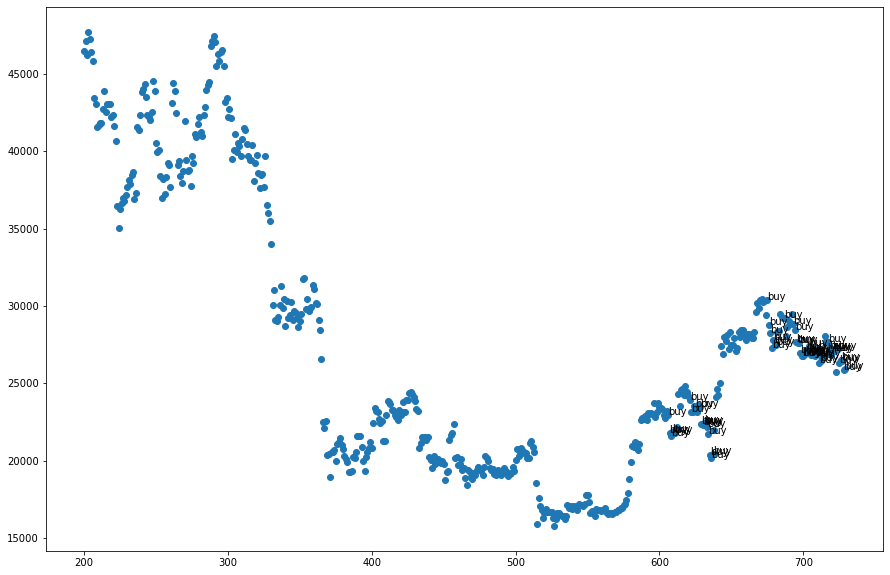

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(df.index,df['open'])
for i in range(0,len(df)):
    
    if df.iloc[i,13]==1:
        
        plt.annotate('buy',(i+200,df.iloc[i,1]))
plt.show()